# Implementing DIPZ

In [14]:
""" layers.py file"""
# taken from myself:
#
# https://github.com/dguest/flow-network/blob/8acc708469ab45ee221d46fbd036f61de20fc2a5/SumLayer.py#L4-L29
#
# Also exists in umami
#
# https://gitlab.cern.ch/atlas-flavor-tagging-tools/algorithms/umami/-/blob/5431cce00f0a120e31e6becf3b06592c3de4edd8/umami/train_tools/NN_tools.py#L1232-1260

from tensorflow.keras.layers import Layer
from tensorflow.keras import backend as K

class Sum(Layer):
    """
    Simple sum layer

    The tricky bits are getting masking to work properly, but given
    that time distributed dense layers _should_ compute masking on
    their own.
    """

    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.supports_masking = True

    def build(self, input_shape):
        pass

    def call(self, x, mask=None):
        if mask is not None:
            x = x * K.cast(mask, K.dtype(x))[:,:,None]
        return K.sum(x, axis=1)

    def compute_output_shape(self, input_shape):
        return input_shape[0], input_shape[2]

    def compute_mask(self, inputs, mask):
        return None


In [15]:
""" train.py file"""

#!/usr/bin/env python3

"""
Train dipz with keras
"""
#'Take only this many inputs (with no args %(const)s)'
_h_take_first = 'Take only this many inputs (with no args %(const)s)'
#'../../user.viruelas.27383479._000001.output.h5'  

# TODO: clean up these hardcoded values
MASK_VALUE = 999
MERGED_NODES = [32]*4

# own all the libs



# local libs
#from layers import Sum

# mlearnin libs
import numpy as np
import tensorflow.keras as keras
from tensorflow.keras import backend as K
import tensorflow as tf
from tensorflow.keras.layers import (
    Dense, TimeDistributed, Input, Concatenate, Masking
)
from keras.utils.generic_utils import CustomMaskWarning

# the data libs
import h5py
import json

# random python utility libs
from argparse import ArgumentParser
from pathlib import Path
import warnings

def get_args():
    parser = ArgumentParser(description=__doc__)
    parser.add_argument('h5_inputs', type=Path)
    parser.add_argument('-c', '--config-file', type=Path, required=True)
    parser.add_argument('-o', '--output-dir',
                        type=Path, default=Path('outputs'))
    parser.add_argument('-f', '--take-first', type=int, const=100, nargs='?',
                        help=_h_take_first)
    parser.add_argument('-e', '--epochs', type=int, default=10)
    return parser.parse_args()

def get_model(config, mask_value):
    n_track_inputs = len(config['trackfeatnames'])
    track_inputs = Input(shape=(None,n_track_inputs))

    n_jet_inputs = len(config['jetfeatnames'])
    jet_inputs = Input(shape=(n_jet_inputs))

    # add jet layers
    x = jet_inputs
    for nodes in config['jetnodes']:
        x = Dense(units=nodes, activation='relu')(x)
    jet_latent = x

    # add track layers
    x = track_inputs
    x = Masking(mask_value=mask_value)(x)
    for nodes in config['tracknodes']:
        x = TimeDistributed(Dense(nodes, activation='relu'))(x)
    x = Sum()(x)
    track_latent = x

    # merge the layers
    merged = Concatenate()([jet_latent, track_latent])
    # todo: not clear how many additonal processing layers we should
    # add here
    x = merged
    for nodes in MERGED_NODES:
        x = Dense(nodes, activation='relu')(x)
    out_latent = x
    outputs = keras.layers.Dense(units=2)(out_latent)
    model = keras.Model(
        inputs=[jet_inputs, track_inputs],
        outputs=outputs)
    # print the summary
    model.summary()
    model.compile(optimizer=keras.optimizers.Adam(),
                  loss=gaussian_loss)
    return model

# transforms
def scale(scale, altname=None):
    def trf(x):
        return x * scale
    trf.scale = scale
    trf.altname = altname
    return trf

def renamed(new):
    trf = lambda x: x
    trf.scale = 1.0
    trf.altname = new
    return trf

log_named = lambda x: np.log(x)
log_named.scale = 1.0
log_named.altname = 'log_pt'

TRANSFORMS = {
    'pt': log_named,
    'pt_btagJes': log_named,
    'detectorZ0': scale(0.02, "z0RelativeToBeamspot"),
    'primaryVertexDetectorZ': scale(0.02),
    'eta_btagJes': renamed('eta'),
}

def build_feature(name):
    offset = 0.0
    scale = 1.0
    if trf := TRANSFORMS.get(name):
        name = trf.altname or name
        scale = trf.scale
    return {'name': name, 'offset': offset, 'scale': scale}

def get_inputs(jet_feature_names, track_feature_names):
    track_variables = [build_feature(x) for x in track_feature_names]
    jet_variables = [build_feature(x) for x in jet_feature_names]
    return {
        'input_sequences': [
            {
                'name': 'tracks_loose202102NoIpCuts_absD0DescendingSort',
                'variables': track_variables,
            }
        ],
        'inputs': [
            {
                'name': 'btagging',
                'variables': jet_variables
            }
        ],
        'outputs': [
            {
                'labels': ['z','negLogSigma2'],
                'name': 'dipz'
            }
        ]
    }

def get_dataset(h5file_path, config, mask_value, take_first=False):
    """
    We make some hardcoded transformations to normalize these inputs
    """

    # pt is log transformed
    # Z0 is divided by 50
    # target is divided by 50

    trf = TRANSFORMS
    # identy function to pass through things that aren't listed above
    def ident(x):
        return x

    sl = slice(None,None,None)
    if take_first:
        sl = slice(0,take_first,None)

    with h5py.File(h5file_path) as h5file:
        # get track array
        td = h5file['fs_tracks_simple_ip']
        tfn = config['trackfeatnames']
        # we can pass through NaNs here
        with np.errstate(invalid='ignore'):
            trackstack = [trf.get(x,ident)(td[x,sl,...]) for x in tfn]
        track_array = np.stack(trackstack, axis=2)
        invalid = np.isnan(td['pt',sl])
        track_array[invalid,:] = mask_value

        # get jet array
        jd = h5file['jets']
        jfn = config['jetfeatnames']
        jetstack = [trf.get(x,ident)(jd[x,sl]) for x in jfn]
        jet_array = np.stack(jetstack, axis=1)

        # get targets
        tfn = config['targetfeatnames']
        targetstack = [trf.get(x,ident)(jd[x,sl]) for x in tfn]
        target_array = np.stack(targetstack, axis=1)

    return jet_array, track_array, target_array

def gaussian_loss(targ, pred):
    """
    Basic gaussian loss model. Probably not properly normalized
    """
    z = pred[:,0:1]
    q = pred[:,1:2]
    loss = -q + K.square(z - targ) * K.exp(q)
    return loss

def get_gaussian_loss_prec(epsilon):
    def gaussian_loss_prec(targ, pred):
        """
        This seems to be more stable than the gaussian loss above
        """
        z = pred[:,0:1]
        prec = K.abs(pred[:,1:2]) + epsilon
        loss = - K.log(prec) + K.square(z - targ) * prec
        return loss
    return gaussian_loss_prec

def get_config(config_path):
    with open(config_path) as cfg:
        config = json.load(cfg)
    return dict(
        jetfeatnames=config["jetfeatnames"],
        trackfeatnames=config["trackfeatnames"],
        targetfeatnames=config["targetfeatnames"],
        batch_size=config["batch_size"],
        epoch_size=config["epoch_size"],
        number_epochs=config["number_epochs"],
        learning_rate=config["lr"],
        tracknodes=config['tracknodes'],
        jetnodes=config['jetnodes'],
    )

def save_model(model, output_dir, inputs):
    output_dir.mkdir(exist_ok=True, parents=True)
    with open(output_dir / 'architecture.json', 'w') as arch:
        with warnings.catch_warnings():
            warnings.filterwarnings('ignore', category=CustomMaskWarning)
            arch.write(model.to_json(indent=2))

    model.save_weights(output_dir / 'weights.h5')

    with open(output_dir / 'inputs.json', 'w') as inputs_file:
        json.dump(inputs, inputs_file, indent=2)

def dump_prediction(model, jet_inputs, track_inputs, targets):
    pred = model.predict([jet_inputs, track_inputs])
    z = pred[:,0]
    zhat = targets[:,0]
    widths = np.sqrt(np.exp(-pred[:,1])) #Standard Deviation
    sigma = (z - zhat) / widths 
    print(np.stack([z, zhat, widths, sigma]).T[:20])
    return z, zhat, widths, sigma

#def run():
mask_value = MASK_VALUE
#args = get_args()
config = get_config("../regress.json")
model = get_model(config, mask_value=mask_value)
jet_inputs, track_inputs, targets = get_dataset(
    "../user.viruelas.27383479._000001.output.h5", config, mask_value)
model.fit([jet_inputs, track_inputs], targets, epochs=100)
z, zhat, widths, sigma = dump_prediction(model, jet_inputs, track_inputs, targets)
inputs = get_inputs(config['jetfeatnames'], config['trackfeatnames'])
save_model(model, inputs=inputs, output_dir=Path('outputs'))

#if __name__ == '__main__':
#run()


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, None, 8)]    0           []                               
                                                                                                  
 masking_1 (Masking)            (None, None, 8)      0           ['input_3[0][0]']                
                                                                                                  
 input_4 (InputLayer)           [(None, 2)]          0           []                               
                                                                                                  
 time_distributed_4 (TimeDistri  (None, None, 16)    144         ['masking_1[0][0]']              
 buted)                                                                                     

18173/18173 [==============================] - 23s 1ms/step - loss: -4.3738
Epoch 42/100
18173/18173 [==============================] - 23s 1ms/step - loss: -4.3583
Epoch 43/100
18173/18173 [==============================] - 23s 1ms/step - loss: -4.3445
Epoch 44/100
18173/18173 [==============================] - 23s 1ms/step - loss: -4.2755
Epoch 45/100
18173/18173 [==============================] - 23s 1ms/step - loss: -4.2116
Epoch 46/100
18173/18173 [==============================] - 23s 1ms/step - loss: -4.2830
Epoch 47/100
18173/18173 [==============================] - 23s 1ms/step - loss: -4.1725
Epoch 48/100
18173/18173 [==============================] - 23s 1ms/step - loss: -4.2244
Epoch 49/100
18173/18173 [==============================] - 23s 1ms/step - loss: -4.4474
Epoch 50/100
18173/18173 [==============================] - 23s 1ms/step - loss: -4.2629
Epoch 51/100
18173/18173 [==============================] - 23s 1ms/step - loss: -4.2313
Epoch 52/100
18173/18173 [========

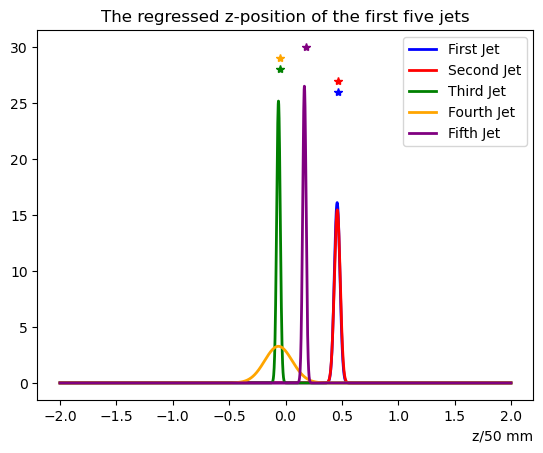

In [23]:
'''Plotting the jets' regressed z-position'''
import matplotlib.pyplot as plt
from scipy.stats import norm

#z-axis ranges from -2 and 2 with .001 steps
x = np.arange(-2, 2, 0.001)
    
plt.plot(x, norm.pdf(x, z[0], widths[0]), color='blue', linewidth=2, label='First Jet')
plt.plot(zhat[0], 26, marker='*', color="blue")
plt.plot(x, norm.pdf(x, z[1], widths[1]), color='red', linewidth=2, label='Second Jet')
plt.plot(zhat[1], 27, marker='*', color="red")
plt.plot(x, norm.pdf(x, z[2], widths[2]), color='green', linewidth=2, label='Third Jet')
plt.plot(zhat[2], 28, marker='*', color="green")
plt.plot(x, norm.pdf(x, z[3], widths[3]), color='orange', linewidth=2, label='Fourth Jet')
plt.plot(zhat[3], 29, marker='*', color="orange")
plt.plot(x, norm.pdf(x, z[4], widths[4]), color='purple', linewidth=2, label='Fifth Jet')
plt.plot(zhat[4], 30, marker='*', color="purple")
plt.xlabel("z/50 mm", loc='right')
plt.title('The regressed z-position of the first five jets')
plt.legend()
plt.show()
#plt.cla()

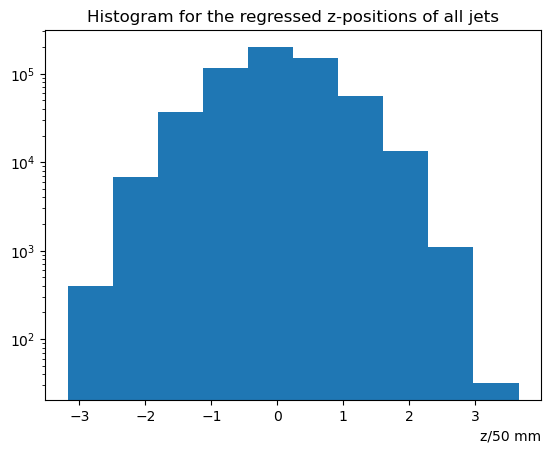

In [17]:
"""Plotting a histogram of the regressed z-positions of all jets"""
plt.hist(z, bins=10)
plt.yscale("log")
plt.title('Histogram for the '+ 'regressed z-positions' +' of all jets')
plt.xlabel("z/50 mm", loc='right')
plt.show()

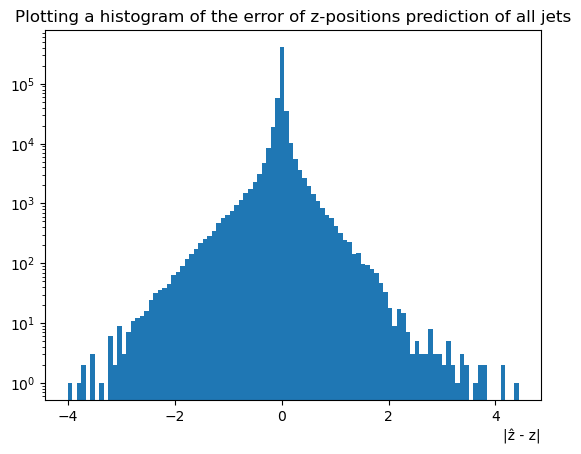

In [18]:
"""Plotting a histogram of the error of z-positions predictionof all jets"""
plt.hist(zhat-z, bins=100)
plt.yscale('log')
plt.title('Plotting a histogram of the error of z-positions prediction of all jets')
plt.xlabel("|z\u0302 - z|", loc='right')
plt.show()

In [19]:
############NEEDS TO BE EDITED, IT IS WRONG IMPLEMENTATION#################################
"""Plotting the maximum log of the likelihood"""
def maxloglikelihood(x, y, s):
    loss = []
    count = 0
    for i in range(x.shape[0]):
        if s[i] != 0:
            loss.append(-np.log((1/s[i]) * np.exp(- ((x[i] - y[i])**2) / (2*(s[i])**2) )))
        else: count = count + 1
    print ("number of zero sigmas:", count)    
    return loss

loss = np.asarray(maxloglikelihood(z,zhat,widths))

/var/folders/l3/2httnx650539mb_cn3qm_z80cc_3b_/T/ipykernel_12443/1504265362.py:8: RuntimeWarning: divide by zero encountered in log
  loss.append(-np.log((1/s[i]) * np.exp(- ((x[i] - y[i])**2) / (2*(s[i])**2) )))


number of zero sigmas: 0


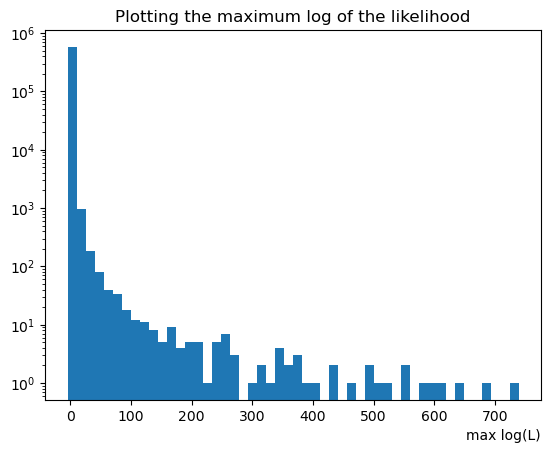

In [20]:
loss = loss[loss < 1000000000]
plt.hist(loss, bins=50)
plt.yscale('log')
plt.title('Plotting the maximum log of the likelihood')
plt.xlabel("max log(L)", loc='right')
plt.show()

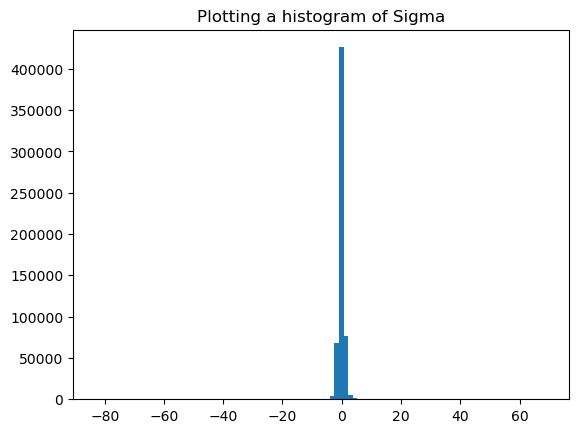

In [21]:
plt.hist(sigma, bins=100)
#plt.yscale('log')
plt.title('Plotting a histogram of Sigma')
plt.xlabel("", loc='right')
plt.show()

In [22]:
print(np.std(sigma))

1.0319686
